<a href="https://colab.research.google.com/github/GrabowMar/NNproject/blob/main/Projekt_Sieci_Neuronowe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
# Importing standard libraries
import os
import random
import math

# Importing third-party libraries
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm
import tensorflow as tf

# Importing Kaggle API handler (ensure installation in the environment)
# Note: Ensure `kaggle` is installed: pip install kaggle
import kagglehub


In [3]:
# Mount Google Drive for accessing Kaggle files and storing data
from google.colab import drive
drive.mount('/content/drive')

# Set the Kaggle configuration directory for API access
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

# Download the dataset using Kaggle API
!kaggle datasets download -d nipunarora8/age-gender-and-ethnicity-face-data-csv -p /content/drive/MyDrive/kaggle

# Extract the dataset from the downloaded zip file
import zipfile

# Define file paths for the downloaded zip and extraction destination
file_path = '/content/drive/MyDrive/kaggle/age-gender-and-ethnicity-face-data-csv.zip'
extraction_path = '/content/drive/MyDrive/kaggle'

# Extract the contents of the zip file
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Load the dataset into a Pandas DataFrame and display basic information
import pandas as pd
data_path = '/content/drive/MyDrive/kaggle/age_gender.csv'

# Load the CSV data
data = pd.read_csv(data_path)

# Display a preview of the dataset
print("Dataset loaded successfully! Here's a preview of the first few rows:")
print(data.head())  # Display only the first few rows for better readability

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv
License(s): copyright-authors
age-gender-and-ethnicity-face-data-csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset loaded successfully! Here's a preview of the first few rows:
   age  ethnicity  gender                        img_name  \
0    1          2       0  20161219203650636.jpg.chip.jpg   
1    1          2       0  20161219222752047.jpg.chip.jpg   
2    1          2       0  20161219222832191.jpg.chip.jpg   
3    1          2       0  20161220144911423.jpg.chip.jpg   
4    1          2       0  20161220144914327.jpg.chip.jpg   

                                              pixels  
0  129 128 128 126 127 130 133 135 139 142 145 14...  
1  164 74 111 168 169 171 175 182 184 188 193 199...  
2  67 70 71 70 69 67 70 79 90 103 116 132 145 155...  
3  193 197 198 200 199 200 202 203 204 205 208 21...  
4  202 205 

In [4]:
# Check for missing values in the dataset
missing_values = data.isnull().sum()
print("Missing values in the dataset:\n", missing_values)

# Separate features (pixels) and target (ethnicity)
x = data[["pixels"]].copy()
y = data[["ethnicity"]].copy()

# Free up memory by deleting the original dataset
del data

# Preview the first few rows of features and target data
print("Feature data (x) preview:\n", x.head(), "\n")
print("Target data (y) preview:\n", y.head())

# Calculate image dimensions from the pixel data
num_pixels = len(x["pixels"][0].split(" "))
img_height, img_width = int(np.sqrt(num_pixels)), int(np.sqrt(num_pixels))
print(f"Number of pixels: {num_pixels}, Image dimensions: {img_height}x{img_width}")

# Convert the pixel strings into a 4D NumPy array
# Step 1: Split pixel strings into lists of integers
x = x["pixels"].apply(lambda pixel_string: np.array(list(map(int, pixel_string.split()))))

# Step 2: Reshape into 4D array (number of samples, height, width, channels)
x = np.stack(x.values, axis=0).reshape(-1, img_height, img_width, 1)

# Step 3: Normalize pixel values to the range [0, 1]
x = x / 255.0

# Display the shape of the processed feature data
print("Processed feature data shape (x):", x.shape)


Missing values in the dataset:
 age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64
Feature data (x) preview:
                                               pixels
0  129 128 128 126 127 130 133 135 139 142 145 14...
1  164 74 111 168 169 171 175 182 184 188 193 199...
2  67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3  193 197 198 200 199 200 202 203 204 205 208 21...
4  202 205 209 210 209 209 210 211 212 214 218 21... 

Target data (y) preview:
    ethnicity
0          2
1          2
2          2
3          2
4          2
Number of pixels: 2304, Image dimensions: 48x48
Processed feature data shape (x): (23705, 48, 48, 1)


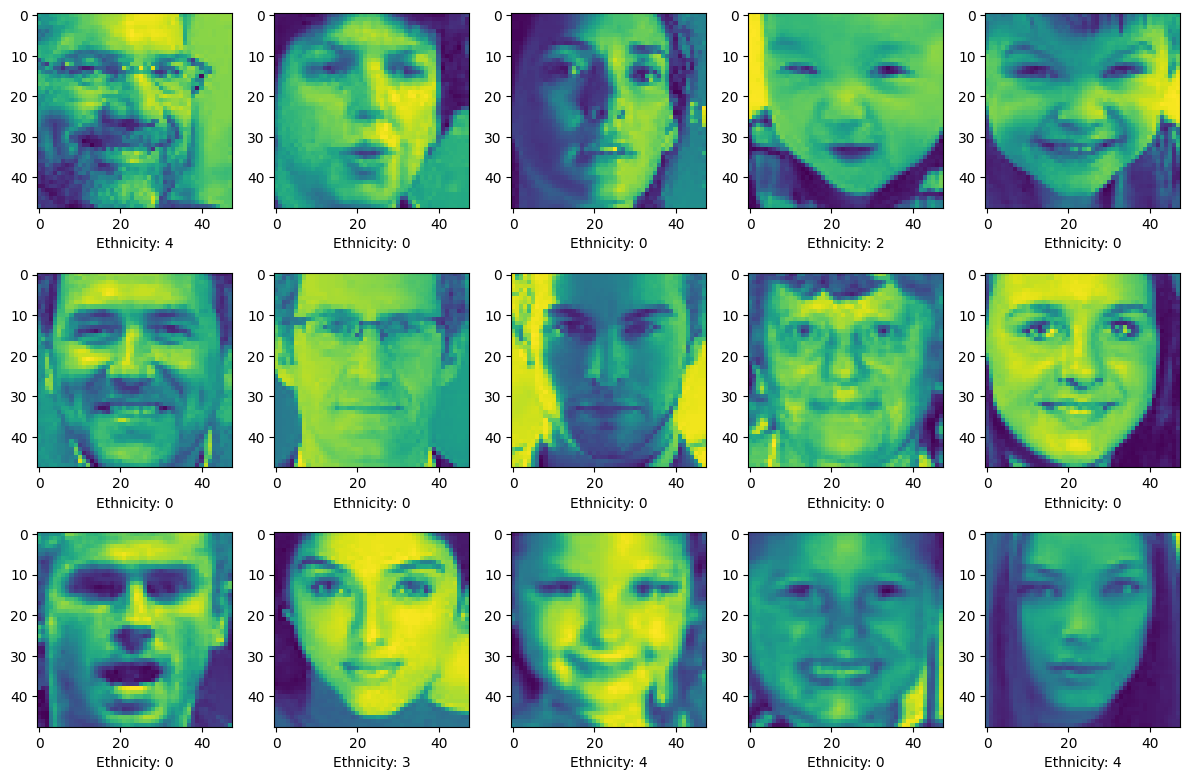

In [5]:
# Set up the figure for displaying images
plt.figure(figsize=(12, 8))
random_indices = np.random.randint(0, x.shape[0], 16)  # Generate random indices

# Loop through randomly selected indices and plot the images
for i, subplot_index in zip(random_indices, range(1, 16)):
    plt.subplot(3, 5, subplot_index)  # Create a 3x5 grid of subplots

    plt.imshow(x[i].squeeze())  # Display the image in grayscale
    plt.xlabel(f"Ethnicity: {y['ethnicity'].iloc[i]}")  # Label with ethnicity

# Show the plotted images
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
# Convert ethnicity column into a matrix and apply one-hot encoding
ethnicity_matrix = np.array(y["ethnicity"])
ethnicity_labels = to_categorical(ethnicity_matrix, num_classes=5)

# Split the data into training, validation, and test sets
# Initial split: 60% training, 40% temporary (validation + test)
x_train, x_temp, ethnicity_train, ethnicity_temp = train_test_split(
    x, ethnicity_labels, test_size=0.4, random_state=42
)

# Second split: Split the temporary set equally into validation and test sets (20% each)
x_val, x_test, ethnicity_val, ethnicity_test = train_test_split(
    x_temp, ethnicity_temp, test_size=0.5, random_state=42
)

# Display the shapes of the resulting splits for verification
print("Dataset shapes after splitting:")
print(f"x_train shape: {x_train.shape}, x_val shape: {x_val.shape}, x_test shape: {x_test.shape}")
print(f"ethnicity_train shape: {ethnicity_train.shape}, ethnicity_val shape: {ethnicity_val.shape}, ethnicity_test shape: {ethnicity_test.shape}")


Dataset shapes after splitting:
x_train shape: (14223, 48, 48, 1), x_val shape: (4741, 48, 48, 1), x_test shape: (4741, 48, 48, 1)
ethnicity_train shape: (14223, 5), ethnicity_val shape: (4741, 5), ethnicity_test shape: (4741, 5)


In [15]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

model = Sequential([
    layers.InputLayer(input_shape=(48, 48, 1)),
    layers.RandomZoom(0.05),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Dropout(0.075),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')
])



# Display the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_zoom (RandomZoom)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,142,021 (4.36 MB)

 Trainable params: 1,142,021 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# Define batch size
batch_size = 80

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Set up early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    mode='max',              # Look for maximum validation accuracy
    patience=3,              # Stop after 3 epochs with no improvement
    verbose=1                # Log early stopping information
)

# Train the model
history = model.fit(
    x_train, ethnicity_train,              # Training data
    epochs=15,                             # Number of epochs
    batch_size=batch_size,                 # Batch size
    validation_data=(x_val, ethnicity_val),  # Validation data
    callbacks=[early_stop]                 # Include early stopping callback
)

# Display a message after training completion
print("\nModel training complete.")

Epoch 1/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.4584 - loss: 1.3496 - val_accuracy: 0.6615 - val_loss: 0.9256
Epoch 2/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6790 - loss: 0.8999 - val_accuracy: 0.7152 - val_loss: 0.7953
Epoch 3/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7190 - loss: 0.7930 - val_accuracy: 0.7380 - val_loss: 0.7643
Epoch 4/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7533 - loss: 0.7086 - val_accuracy: 0.7475 - val_loss: 0.7174
Epoch 5/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7595 - loss: 0.6854 - val_accuracy: 0.7591 - val_loss: 0.6994
Epoch 6/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7821 - loss: 0.6246 - val_accuracy: 0.7730 - val_loss: 0.6689
Epoch 7/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7833 - loss: 0.6100 - val_accuracy: 0.7646 - val_loss: 0.6957
Epoch 8/15
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7982 - loss: 0.5733 - val_accu

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7624 - loss: 0.6772
Test Loss: 0.6496, Test Accuracy: 0.7730


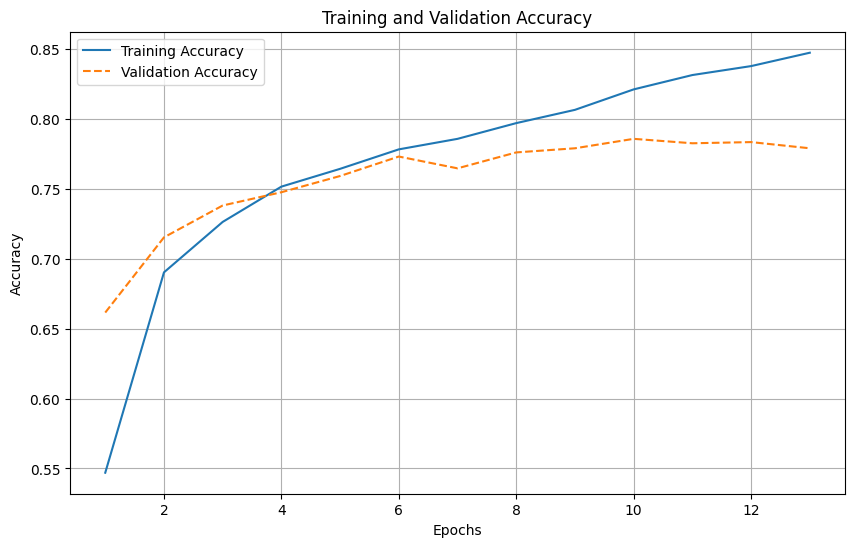

In [17]:
import matplotlib.pyplot as plt

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, ethnicity_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Check training and validation accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Ensure accuracy visualization is dynamic and not hardcoded
def training_history_visualization(history, max_epochs):
    """Visualizes training and validation accuracy over epochs."""
    epochs = range(1, len(history.history['accuracy']) + 1)  # Dynamic epoch range

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history.history['accuracy'], label="Training Accuracy")
    plt.plot(epochs, history.history['val_accuracy'], label="Validation Accuracy", linestyle="--")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize the training history
training_history_visualization(history, len(train_accuracy))


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


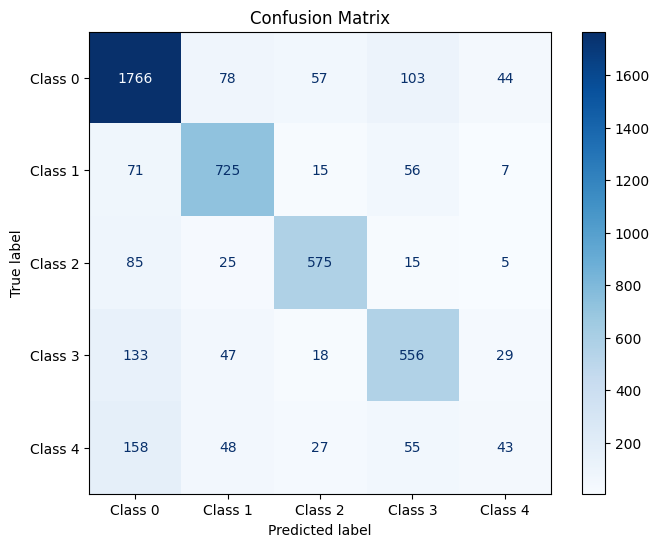

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Import necessary functions


# Predict the test set labels
ethnicity_pred = model.predict(x_test)
ethnicity_pred = np.argmax(ethnicity_pred, axis=1)  # Get predicted class labels
ethnicity_test_labels = np.argmax(ethnicity_test, axis=1)  # Get true class labels

# Define class names
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"]

# Function to plot confusion matrix
def plot_confusion_matrix_from_dataset(true_labels, pred_labels, class_names):
    """Plots a confusion matrix with given true and predicted labels."""
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Display the confusion matrix
    plt.figure(figsize=(8, 6))
    disp.plot(cmap="Blues", values_format='d', ax=plt.gca())
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix_from_dataset(ethnicity_test_labels, ethnicity_pred, class_names)